**DESCRIPTION OF THE PROBLEM:**

The problem of proposing item prices: The current pricing of products is difficult on a large scale because items are priced in many different ways such as clothing that prices products according to seasons, while the price of electronic products is priced according to its specifications. Through this, We want to build an algorithm to automatically suggest appropriate product prices to sellers based on the information they provide such as product category name, brand name and item status.

In [1]:

import numpy as np 
import pandas as pd 
import time
import lzma
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

**I.Check input data:**

In [2]:
#Read input data ::
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test_stg2.tsv', sep='\t')
print("train data: ",train.shape)
print("test data: ",test.shape)

train data:  (1482535, 8)
test data:  (3460725, 7)


In [3]:
#Train file information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [4]:
#List of first 10 items: 
train.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...


In [5]:
# Check the information in the test file
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460725 entries, 0 to 3460724
Data columns (total 7 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   test_id            int64 
 1   name               object
 2   item_condition_id  int64 
 3   category_name      object
 4   brand_name         object
 5   shipping           int64 
 6   item_description   object
dtypes: int64(3), object(4)
memory usage: 184.8+ MB


In [6]:
test.head(10)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...
5,5,iPhone 6 Plus or 6s Plus Vodka pink case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,1,One Absolut Vodka in Pink for iPhone 6 Plus an...
6,6,Vintage Cameo Pendant & Brooch Pin,3,Women/Jewelry/Necklaces,Vintage,1,Two vintage Cameo pieces. 1. Silver metal Lock...
7,7,Rose Gold Stainless Steel Quartz Watch,1,Women/Women's Accessories/Watches,NaN,1,Brand new Price firm No trades Box included wi...
8,8,Daisy Marc Jacobs 3.4oz,3,Beauty/Fragrance/Women,MARC JACOBS,0,Brand new No box 100% authentic Firm price NO ...
9,9,Rose Brushes and Silicone Sponge,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,1,All new. 12 pcs makeup brushes and one Silicon...


-The train file has 1482535 product and the test file has 3460725 product

-We can see that in the train file there is an additional price column compared to the test file

-In an item catalogue with multiple items with null data in column brand_name (shown as NaN)

**II. INPUT DATA PROCESSING**

1.Check the data:

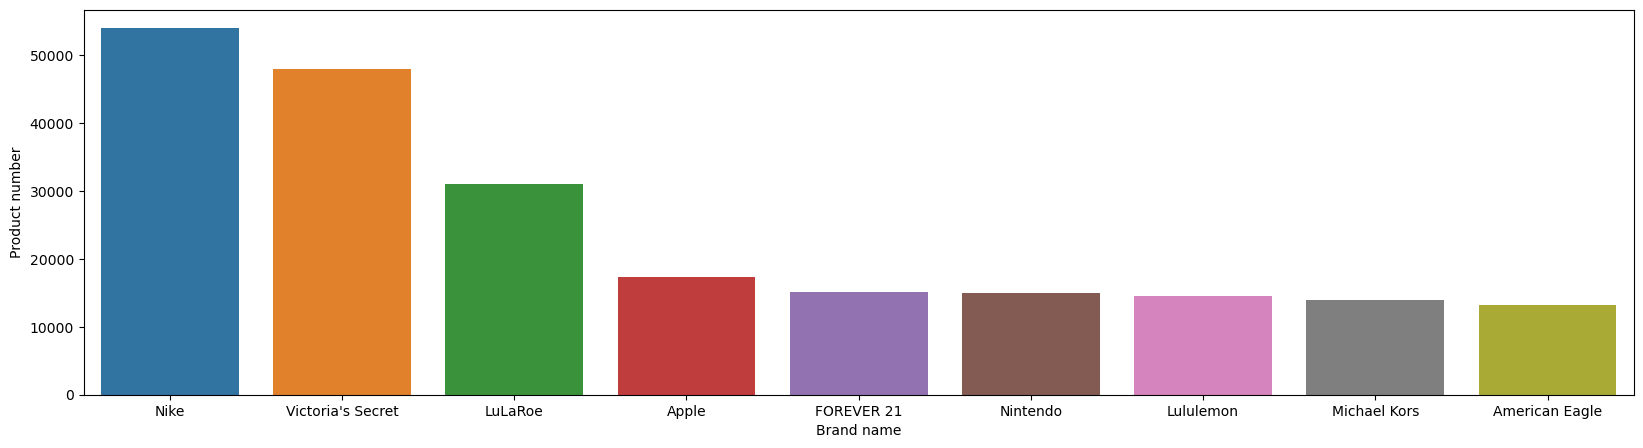

In [7]:
unique_brands = train['brand_name'].value_counts()
plt.figure(figsize=(20, 5))
sns.barplot(x=unique_brands.index[1:10], y=unique_brands[1:10])
plt.xlabel('Brand name')
plt.ylabel('Product number')
plt.show()

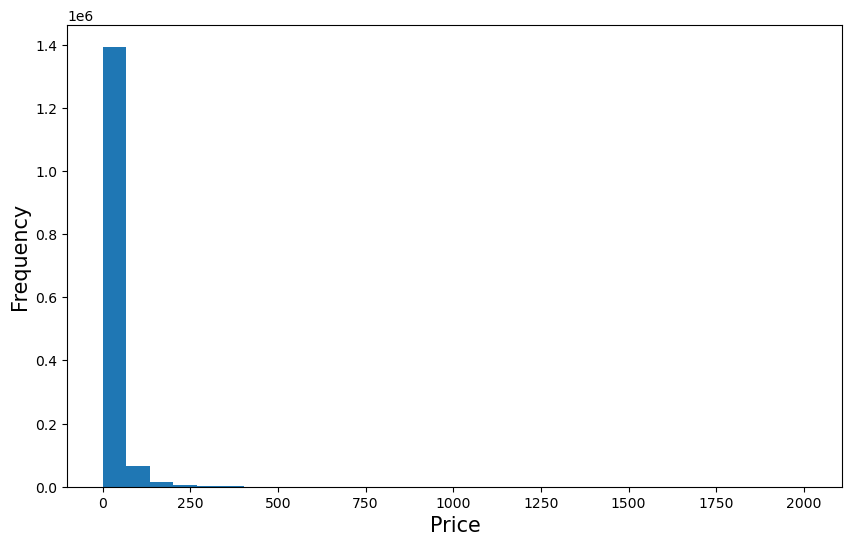

In [8]:
# Review of the price:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(train.price,bins = 30, range = [min(train.price), max(train.price)],label="Price")
ax.set_xlabel('Price',fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
plt.show()

-We have many concentrated price items below $ 500, the distribution of prices is skewed right

-Using a covariate function returns the normal distribution:

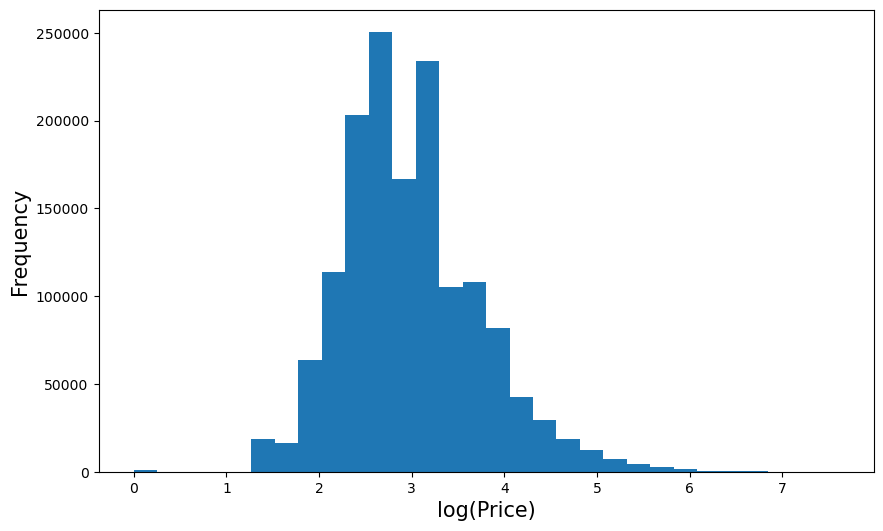

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(np.log1p(train['price']),bins = 30, range = [min(np.log1p(train['price'])), max(np.log1p(train['price']))],label="Price")
ax.set_xlabel('log(Price)',fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
plt.show()

-Check the condition of the product:

Text(0.5, 0, 'Product conditions')

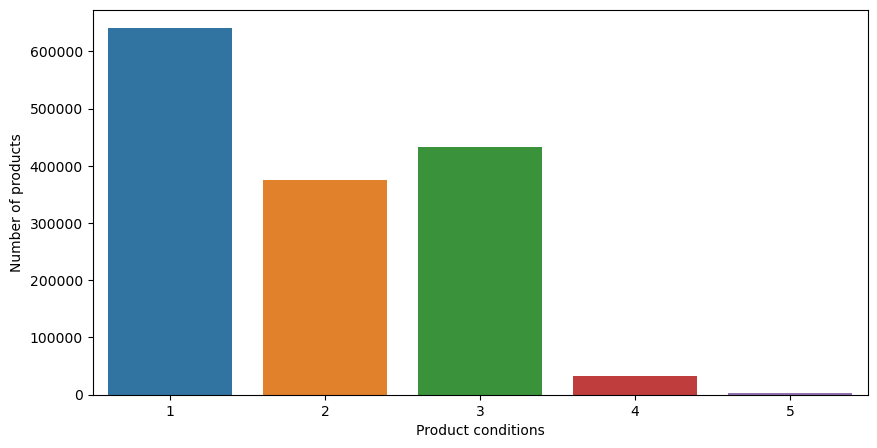

In [10]:
count = train['item_condition_id'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=count.index[:5], y=count[:5])
plt.ylabel('Number of products')
plt.xlabel('Product conditions')

-Check shipping fees:

Text(0.5, 0, 'Shipping fee')

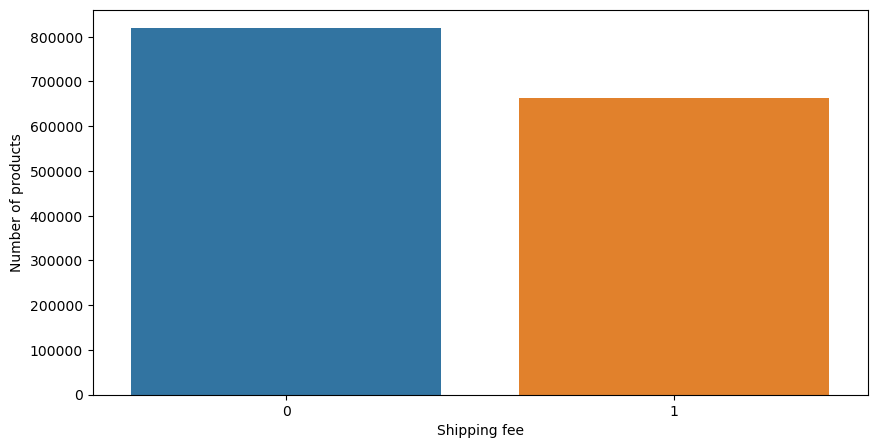

In [11]:
count = train['shipping'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=count.index[:2], y=count[:2])
plt.ylabel('Number of products')
plt.xlabel('Shipping fee')

-The majority of sps without shipping fees account for about 55% and the remaining 45% do not have ships;

**III.Data processing:**

-In column category_name there are items separated by the '/' sign, so we will divide into 3 columns for easy handling

In [12]:
def split_cat(text):
    try: return text.split("/")
    except: return ("None", "None", "None")
train['category_1'], train['category_2'], train['category_3'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
test['category_1'], test['category_2'], test['category_3'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))

#Review data after splitting
train.head(5)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_1,category_2,category_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


-Check the data in the train and test if it is null

In [13]:
train.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
category_1                0
category_2                0
category_3                0
dtype: int64

In [14]:
test.isnull().sum()

test_id                    0
name                       0
item_condition_id          0
category_name          14833
brand_name           1476490
shipping                   0
item_description           6
category_1                 0
category_2                 0
category_3                 0
dtype: int64

-We see null data in the train file and the test is concentrated in columns category_name, brand_name and item_description

-Null data processing:

In [15]:
def handle_missing(dataset):
    dataset.brand_name.fillna(value="None", inplace=True)
    dataset.item_description.fillna(value="None", inplace=True)
    dataset.category_name.fillna(value="None", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)

In [16]:
#Check if the data is null
train.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
category_1           0
category_2           0
category_3           0
dtype: int64

**IV. EXPERIMENT** 

In [17]:
#Group product names by its price
def create_price_d(grouped, operation_name, orig_colname):
    price_d = {}
    for index, row in grouped.iterrows():
        price_d[row[orig_colname]] = row['price']
    return {orig_colname + "_" + operation_name: price_d}


# Generate data to look up prices by product name
price_d = {}    
for col in ['brand_name','category_1','category_2','category_3' ,'category_name']:
    price_d.update(create_price_d(train.groupby(col, as_index=False).min(), 'min', col))
    price_d.update(create_price_d(train.groupby(col, as_index=False).median(), 'median', col))
    price_d.update(create_price_d(train.groupby(col, as_index=False).mean(), 'mean', col))
    price_d.update(create_price_d(train.groupby(col, as_index=False).max(), 'max', col))

    
#Include columns containing product prices in the data
def price_dt(dt, pricedicts):
    for col in ['brand_name','category_1','category_2','category_3','category_name']:
        for oper in ['_min', '_median', '_mean', '_max']:
            dt[col + oper] = dt[col].map(price_d[col + oper])
            dt[col + oper] = dt[col + oper].fillna(price_d[col + oper].get('Unknown', 5))

price_dt(train, price_dt)
price_dt(test, price_dt)

C:\Users\HP\AppData\Local\Temp\ipykernel_19756\1201622078.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  price_d.update(create_price_d(train.groupby(col, as_index=False).median(), 'median', col))
C:\Users\HP\AppData\Local\Temp\ipykernel_19756\1201622078.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  price_d.update(create_price_d(train.groupby(col, as_index=False).mean(), 'mean', col))
C:\Users\HP\AppData\Local\Temp\ipykernel_19756\1201622078.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False.

In [18]:
train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_1,category_2,...,category_2_mean,category_2_max,category_3_min,category_3_median,category_3_mean,category_3_max,category_name_min,category_name_median,category_name_mean,category_name_max
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,None,10.0,1,No description yet,Men,Tops,...,18.999442,375.0,0.0,14.0,18.352495,309.0,0.0,14.0,18.352495,309.0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,...,87.887754,1900.0,3.0,25.0,42.913900,750.0,3.0,25.0,42.913900,750.0
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,...,18.237514,1525.0,0.0,12.0,15.659676,329.0,0.0,12.0,15.660102,329.0
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,None,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,...,21.566301,848.0,0.0,16.0,22.185020,848.0,0.0,16.0,22.185020,848.0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,None,44.0,0,Complete with certificate of authenticity,Women,Jewelry,...,27.501571,2004.0,0.0,12.0,25.587509,1747.0,0.0,12.0,25.587509,1747.0


In [19]:
col = ['item_condition_id', 
       'shipping', 
      'brand_name_min', 
       'brand_name_max', 
       'brand_name_median', 
       'brand_name_mean', 
      'category_name_min', 
       'category_name_max', 
       'category_name_median', 
       'category_name_mean'
      ]

train_col = train[col]
train_pr = train[['price']]

test_col = test[col]

**LinearRegression**

Linear regression is a statistical technique used in predictive analytics.  It models the linear relationship between a dependent variable and one or more independent variables. Care must be taken to avoid overfitting, a situation where the model becomes too specific to the original dataset.                 

The formula of linear regression is: Y = bX + A.


**LightGBM**

LightGBM stands for Light Gradient Boosting Machine, which is an open source processing gradient boosting algorithm developed by Microsoft. Gradient Boosting is an algorithm derived from the Decision Tree algorithm, which performs the sequential construction of multiple Decision Trees and conducts learning.

In [20]:
#Train model using linear regression
regr = linear_model.LinearRegression()
regr.fit(train_col, train_pr)

#Create a price prediction on the test set
test['price'] = regr.predict(test_col)

#Bring price predictions less than 0 to 0
test.loc[test.price < 0, 'price'] = 0


In [21]:
test.head(5)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,category_1,category_2,category_3,...,category_2_max,category_3_min,category_3_median,category_3_mean,category_3_max,category_name_min,category_name_median,category_name_mean,category_name_max,price
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,None,1,Size 7,Women,Jewelry,Rings,...,2004.0,0.0,15.0,32.957465,2004.0,0.0,15.0,32.957465,2004.0,25.496219
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,None,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,...,950.0,0.0,9.0,11.268892,235.0,0.0,9.0,11.268892,235.0,12.589569
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,...,1750.0,0.0,55.0,139.562546,1709.0,0.0,55.0,139.562546,1709.0,112.516602
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,None,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,...,590.0,0.0,17.0,26.924685,327.0,0.0,17.0,27.000960,327.0,24.609692
4,4,Life after Death,3,Other/Books/Religion & Spirituality,None,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,...,180.0,3.0,11.0,13.358423,75.0,3.0,11.0,13.358423,75.0,7.471231


In [22]:
submission_col = test[['test_id','name','price']]
submission_col.to_csv('submission.csv', index=False)
submission_col.head(20)

,test_id,name,price
0,0,"Breast cancer ""I fight like a girl"" ring",25.496219
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",12.589569
2,2,Coach bag,112.516602
3,3,Floral Kimono,24.609692
4,4,Life after Death,7.471231
5,5,iPhone 6 Plus or 6s Plus Vodka pink case,13.319118
6,6,Vintage Cameo Pendant & Brooch Pin,16.853422
7,7,Rose Gold Stainless Steel Quartz Watch,43.582451
8,8,Daisy Marc Jacobs 3.4oz,23.766558
9,9,Rose Brushes and Silicone Sponge,16.168085


In [23]:
train[train['name'].str.contains('iphone case', case=False)].head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_1,category_2,...,category_2_mean,category_2_max,category_3_min,category_3_median,category_3_mean,category_3_max,category_name_min,category_name_median,category_name_mean,category_name_max
300,300,Jordan iPhone case only for plus,1,"Electronics/Cell Phones & Accessories/Cases, C...",Apple,5.0,1,JORDAN IPHONE CASE ONLY FOR IPHONE 6 plus iPho...,Electronics,Cell Phones & Accessories,...,30.142278,1909.0,0.0,10.0,13.17436,1000.0,0.0,10.0,13.174360,1000.0
1184,1184,Camo OtterBox iPhone Case,2,"Electronics/Cell Phones & Accessories/Cases, C...",None,16.0,0,iPhone 5/5s case,Electronics,Cell Phones & Accessories,...,30.142278,1909.0,0.0,10.0,13.17436,1000.0,0.0,10.0,13.174360,1000.0
1350,1350,Michael Kors iPhone Case,3,Women/Women's Accessories/Wallets,Michael Kors,19.0,0,Gold Michael Kors iPhone case for older model ...,Women,Women's Accessories,...,30.930531,1999.0,0.0,23.0,34.39445,906.0,0.0,24.0,34.854473,906.0
1420,1420,Vs pink iphone case 6/6s plus,2,"Electronics/Cell Phones & Accessories/Cases, C...",None,16.0,0,Pink bulky iphone 6 plus/6s plus iphone case,Electronics,Cell Phones & Accessories,...,30.142278,1909.0,0.0,10.0,13.17436,1000.0,0.0,10.0,13.174360,1000.0
2140,2140,New Victoria's Secret iPhone case 6s/6/,1,"Electronics/Cell Phones & Accessories/Cases, C...",Apple,20.0,0,New Victoria's Secret iPhone case,Electronics,Cell Phones & Accessories,...,30.142278,1909.0,0.0,10.0,13.17436,1000.0,0.0,10.0,13.174360,1000.0
